# Custom Circuits
The `Circuit` class provides functionality for the symbolic and numerical analysis of custom circuits.

For a custom circuit, the code **identifies the periodic and extended degrees of freedom, and eliminates the free and frozen modes**. With this, the **symbolic expression of the Hamiltonian** is generated in terms of an appropriate choice of variables.

The `Circuit` class also performs the **numerical diagonalization of the circuit Hamiltonian. Hierarchical diagonalization can be enabled for better runtime/memory perfomance.**

## Defining a custom circuit
The `Circuit` class supports all superconducting circuits consisting of **capacitances**, **inductances**, and **Josephson junctions**.

<div class="alert alert-info">
    
Custom circuit definition
    
A custom circuit is specified in graph format: it is composed of nodes and branches. To get started, label all circuit nodes with integer numbers n=1,2,3,... Every branch connecting two nodes corresponds to a circuit element.
    
For each branch:
   
- specify branch type: `JJ`, `L`, `C` for Josephson junction, inductance, and capacitance
- give the labels of the two nodes connected by the branch
- provide circuit-element parameters (EJ and ECJ, EL, and EC, respectively)
</div>


As a concrete and familiar example, consider the circuit of the zero-pi qubit (nodes already labeled):
   
![zeropi](./zeropi-circ.jpg)

   
The graph of any custom circuit is stored in simple YAML format using the syntax illustrated here:

In [1]:
zp_yaml = """# zero-pi
branches:
- ["JJ", 1,2, EJ = 10, 20]
- ["JJ", 3,4, EJ, 20]
- ["L", 2,3, 0.008]
- ["L", 4,1, 0.009]
- ["C", 1,3, 0.02]
- ["C", 2,4, 0.02]
"""

Alternatively, circuit specifications can be stored and loaded as `yaml` files, following the same syntax. The graph serves as input to create an instance of the `Circuit` class. 


### More on syntax for entering custom circuits

The example above illustrates most of the syntax rules to be followed. Each branch is represented by 

```"<branch-type>", <node_1>, <node_2>, <param-1> [, <param-2>]```

**Branch types and parameters:**

- `C`:  branch parameter is the charging energy $E_C = \frac{e^2}{2C}$
- `L`:  branch parameter is the inductive energy $E_L = \frac{\Phi_0^2}{(2\pi)^2 L}$
- `JJ`: branch parameters are the Josephson energy $E_J$ and junction charging energy $E_{CJ}$

*Example:* `"C", 1, 3, 0.02` is a capacitance connecting nodes 1 and node 3, with charging energy 0.02 GHz.

**Symbolic vs. numerical branch parameters:**

- Branch parameters can be provided as float values, using the energy units set globally (default: GHz)
- A symbol name can be specified along with a default value (e.g., `EJ = 10`). Note that the same symbol can be used to set any other branch parameters in the description. For instance, in the YAML description `zp_yaml` the parameter $EJ$ sets the junction energies for the junctions connecting nodes $(1, 2)$ and $(3, 4).$
- Symbolic output will generally maintain symbolic parameter names. However, for charging energies of systems with more than four nodes, numerical values are the default, since capacitance-matrix inversion makes expressions lengthy.

    
**Ground node:**

- The user can choose whether to include an explicit ground node. This ground node must then be labeled with `0`, and serves as a reference node whose flux is always $\phi_0 = 0$.

## Creating a `Circuit` object
Using the above string defining the zero-pi qubit, we can easily create a `Circuit` object:

In [18]:
import scqubits as scq
import numpy as np
zero_pi = scq.Circuit.from_yaml(zp_yaml, from_file=False, ext_basis="harmonic")

Here, `ext_basis` can be set to `"discretized"` or `"harmonic"`. This chooses the type of basis for the extended degrees of freedom. "discretized" employs "spatial" discretization; meanwhile, "harmonic" prompts a decomposition in a suitable harmonic-oscillator basis.


The creation of a `Circuit` object automatically runs methods for circuit analysis, quantization, and construction of the circuit Hamiltonian matrix. For instance, we can directly access the **symbolic expression of the circuit Hamiltonian**:

In [19]:
zero_pi.sym_hamiltonian()

All generalized coordinates are denoted by $\theta_i$; the conjugate charges are given by $Q_i$ for extended degrees of freedom, and by $n_i$ for periodic degrees of freedom. Offset charges are denoted by $n_{gi}$ and external fluxes are denoted by $\Phi_i$. A detailed description of external fluxes and offset charges is offered below in [External magnetic flux, offset charges](./custom_circuit.ipynb#External-magnetic-flux,-offset-charges).

.. note:
   The coordinates chosen here generally differ from the node variables. In their construction, periodic and extended 
   degrees of freedom are identified and separated. Furthermore, variable elimination is implemented for free and 
   frozen degrees of freedom (if applicable).
   

The **symbolic Lagrangian in terms of node variables** can be accessed via 

In [20]:
zero_pi.sym_lagrangian(vars_type="node")

The equivalent expression of the **Lagrangian in terms of the transformed variables** used in `sym_hamiltonian` is:

In [21]:
zero_pi.sym_lagrangian(vars_type="new")

The classification of the different variables is recorded in `var_categories`:

In [22]:
zero_pi.var_categories

{'periodic': [1], 'extended': [2, 3], 'free': [], 'frozen': []}

The transformation matrix which maps the new variables ($\theta_i$) to the node variables ($\varphi_i$) can be inspected through `transformation_matrix`.

In [23]:
zero_pi.transformation_matrix

array([[ 0., -1.,  1.,  1.],
       [ 1., -1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 0.,  1.,  0.,  1.]])

Alternatively, these mappings can be represented as equations via

In [24]:
zero_pi.variable_transformation()

Each variable index comes with a **cutoff for basis truncation**. A list of the attribute names for these cutoffs can be accessed using:

In [25]:
zero_pi.cutoff_names

['cutoff_n_1', 'cutoff_ext_2', 'cutoff_ext_3']

We must next set these cutoffs to suitable values. The following attributes determine
these properties:

- `cutoff_n_i` - Uses all the charge eigenstates in the range `(-cutoff_n_i, cutoff_n_i)`
- `cutoff_phi_i` - depends on the setting `ext_basis`. When `ext-basis` is set to
    - `"discretized"`: sets the number of points chosen in the phi range in the
      attribute `discretized_phi_range`.
    - `"extended"`:  Sets the number of harmonic oscillator states used to describe the
      extended variable

In [26]:
zero_pi.cutoff_n_1 = 5
zero_pi.cutoff_ext_2 = 10
zero_pi.cutoff_ext_3 = 10

All the discretized phi ranges can be viewed using

In [27]:
zero_pi.discretized_phi_range

Now, we can call `eigenvals()` to obtain **low-lying eigenenergies of the circuit Hamiltonian**: 

In [28]:
zero_pi.eigenvals()

array([-16.81942934, -16.78256481, -16.74570028, -16.70883575,
       -16.67197123, -16.6351067 ])

Increasing the above cutoff values reveals that these eigenvalues have not converged yet. Increasing cutoff values increases the Hilbert space dimension and, thus, increases memory requirements and runtime. A strategy that can help mitigate this problem is the use of hierarchical diagonalization.

## Hierarchical diagonalization

For a large circuit with many degrees of freedoms, a possibly efficient way of obtaining low-lying eigenenergies and eigenstates is to partition the system into several subsystems, and to use the low-lying energy eigenstates of each subsystems as basis states to diagonalize the full system Hamiltonian. The schematic diagram below illustrates how hierarchical diagonalization is performed:

![HD](./custom_circuit_HD.svg)

For the example of the zero-pi qubit, the expression from `sym_hamiltonian` shows that $\theta_2$ corresponds to the harmonic zeta mode of the zero-pi qubit. The remaining variables $\theta_1$ and $\theta_3$ form the primary qubit degrees of freedom and may be considered a "separate", weakly coupled subsystem. 

This idea of a **subsystem hierarchy is made explicit by grouping circuit variable indices in a nested list**:

In [29]:
system_hierarchy = [[1,3], [2]]

This nested list groups variables $1$ and $3$ into one subsystem, and makes variable $2$ a separate subsystem. 

List nesting extends to multiple layers, so that more complex hierarchies can be captured.  
For example, a zero-pi qubit coupled to an oscillator (variable $4$) could be associated with the hierarchy `[[[1,3], [2]], [4]]`.

For convenience, a default list of truncated Hilbert space dimensions is generated by `truncation_template`:

In [30]:
scq.truncation_template(system_hierarchy)

This template obtained this way is meant to provide a list of the right shape. The entries specifying the truncation levels should, of course, be adjusted. 

**To enable hierarchical diagonalization, the system hierarchy and truncation scheme info are handed over to** `configure`:

Hamiltonian terms describing the coupling between two subsystems are displayed via

In [31]:
zero_pi.cutoff_n_1 = 15
zero_pi.cutoff_ext_2 = 80
zero_pi.cutoff_ext_3 = 100
zero_pi.configure(system_hierarchy=system_hierarchy, subsystem_trunc_dims=[150, 80])

Once the hierarchy is set, subsystem Hamiltonians can be viewed via

In [32]:
zero_pi.sym_hamiltonian(subsystem_index=0)  # show Hamiltonian for subsystem 0

In [33]:
zero_pi.sym_interaction((0,1))  # show coupling terms between subsystems 0 and 1

(For the symmetric zero-pi qubit, the zeta mode and the primary qubit degrees of freedom decouple.)

Each subsystem has access to circuit methods, like `eigenvals`. Here are the unconverged (!) eigenenergies for the zeta mode:

In [34]:
zero_pi.subsystems[1].eigenvals()

array([0.01843909, 0.05531727, 0.09219544, 0.12907362, 0.1659518 ,
       0.20282998])

Hierarchical diagonalization allows us to increase variable-specific cutoffs without exploding the dimension of the joint Hilbert space.

In [35]:
zero_pi.subsystems[1].eigenvals()

array([0.01843909, 0.05531727, 0.09219544, 0.12907362, 0.1659518 ,
       0.20282998])

## External magnetic flux, offset charges

All external magnetic fluxes and offset charges are set to zero by default. They are modified by assigning the desired values to the attributes of the class instance.

Each offset charge $n_{gi}$ is associated with a variable $\theta_i$. Only periodic variables have offset charges relevant to the physics. For extended variables, offset charges (as long as time-independent) can always be eliminated from the Hamiltonian by suitable gauge transformations. A list of adjustable offset charge-parameters and their relation to the node offset charges $\{q_{g\mu}\}$ is provided by:

In [36]:
zero_pi.offset_charge_transformation()

Each external flux $\Phi_i$ is associated with a branch in a closed loop of circuit. All the external fluxes, along with their associated closure branches and loop (provided as a list of branches), can be accessed via:

In [37]:
zero_pi.sym_external_fluxes()

{Φ1: (Branch(JJ, 3, 4),
  [Branch(JJ, 1, 2), Branch(L, 2, 3), Branch(L, 4, 1), Branch(JJ, 3, 4)])}

External fluxes (in unit of $2\pi$) and offset charges can be adjusted by simply:

In [38]:
zero_pi.Φ1 = 0.0
zero_pi.ng1 = 0.0

## Visualization
### Simple parameter sweeps
Plotting the energy spectrum with varying one of the circuit parameters works just as for other qubit classes. For example:

Spectral data:   0%|          | 0/21 [00:00<?, ?it/s]

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Φ1', ylabel='energy [GHz]'>)

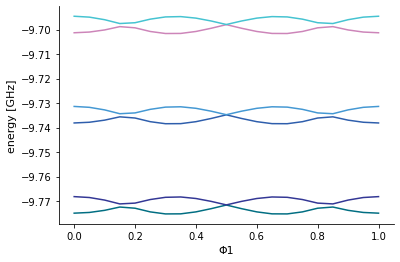

In [39]:
import numpy as np
zero_pi.plot_evals_vs_paramvals("Φ1", np.linspace(0,1,21))


### Potential: symbolic expression and visualization
The expression of the potential is obtained from `potential_symbolic`:

In [40]:
zero_pi.potential_symbolic

The potential can be visualized using `plot_potential`.

For the zero-pi example, there are three degrees of freedoms $(\theta_1, \theta_2, \theta_3)$. We can either fix all but two, or all but one variable. This produces either a contour plot of the potential within the selected 2d region, 

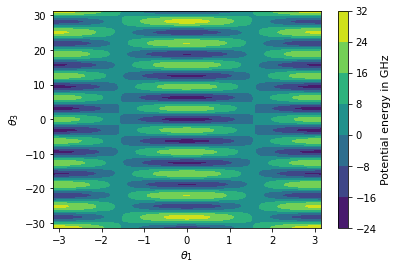

In [41]:
zero_pi.plot_potential(θ1=np.linspace(-np.pi, np.pi), 
                       θ3=np.linspace(-10*np.pi, 10*np.pi, 200), 
                       θ2 = 0.)

or a line plot when only one variable is specified with a range:

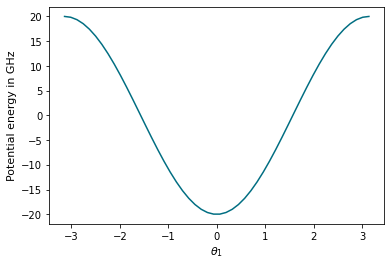

In [42]:
zero_pi.plot_potential(θ1=np.linspace(-np.pi, np.pi), θ3=0, θ2 = 0)

### Plotting the wavefunction
Plots for the probability density of the wavefunction are obtained with `plot_wavefunction`. This method takes two arguments: `which` specifies the energy eigenstate for which the wavefunction is plotted, `var_indices` specifies the variable axis along which the wavefunction is plotted. The probability density is summed over the non-specified variable indices.

In [43]:
zero_pi.sym_hamiltonian()

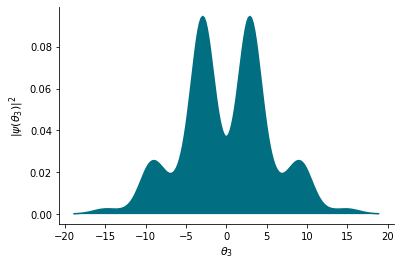

In [44]:
zero_pi.plot_wavefunction(which=0, var_indices=(3,))

A maximum of two variable indices can be specified for a plot:

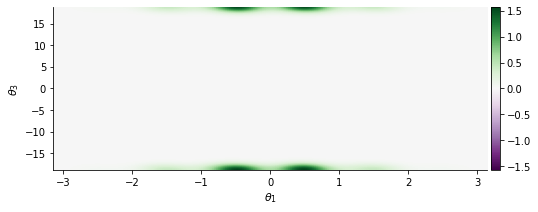

In [111]:
zero_pi.plot_wavefunction(which=0, var_indices=(1,3))

To avoid diagonalizing the system for every call of `plot_wavefunction`, we can
diagonalize the system once using eigensys and use it to plot the wavefunction repeatedly.     

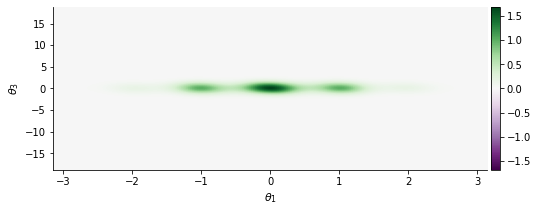

In [45]:
eigensys = zero_pi.eigensys()
zero_pi.plot_wavefunction(which=1, var_indices=(1,3), esys=eigensys)

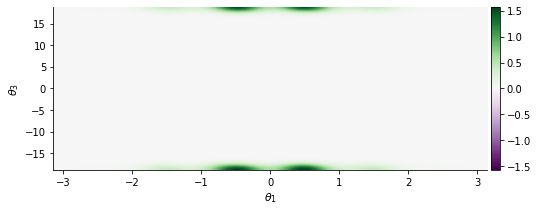

In [46]:
zero_pi.plot_wavefunction(which=0, var_indices=(1,3), esys=eigensys)

## Extra features

### Regroup external fluxes
Grouping of external flux variables with specific circuit branches is not unique in the case of time-independent flux. The user can provide the list of branches with which external fluxes are grouped. (Splitting flux between multiple branches is currently not supported.)

In [47]:
zero_pi.branches

[Branch(JJ, 1, 2),
 Branch(JJ, 3, 4),
 Branch(L, 2, 3),
 Branch(L, 4, 1),
 Branch(C, 1, 3),
 Branch(C, 2, 4)]

In [48]:
closure_branches = [zero_pi.branches[3]]
zero_pi.configure(closure_branches=closure_branches)

### Customize variable transformations
It is possible to carry out variable transformations with a user-defined transformation matrix. For example, if we want to work with a more commonly seen set of variables for zero-pi circuit:

In [49]:
zero_pi = scq.Circuit.from_yaml(zp_yaml, from_file=False, ext_basis="harmonic")
zero_pi.Φ1 = 0.5
zero_pi.ng1 = 0.6

In [50]:
trans_mat = np.array([[ -1,  -1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  -1, -1,  1],
                       [ -1,  1,  -1,  1]])*0.5
zero_pi.configure(transformation_matrix=trans_mat)
zero_pi.variable_transformation()

In [51]:
zero_pi.sym_hamiltonian()

In [52]:
zero_pi.var_categories

{'periodic': [1], 'extended': [2, 3], 'free': [], 'frozen': []}

Notice that all the cutoffs, information about system hierarchy, external fluxes and offset charges are restored to default values when `configure` is called. Therefore, user need to set these attributes:

In [53]:
zero_pi.cutoff_names

['cutoff_n_1', 'cutoff_ext_2', 'cutoff_ext_3']

In [54]:
zero_pi.cutoff_n_1 = 20
zero_pi.cutoff_ext_2 = 30
zero_pi.cutoff_ext_3 = 40
system_hierarchy = [[1,2], [3]]
zero_pi.configure(system_hierarchy=system_hierarchy, subsystem_trunc_dims=[20, 20])

In [55]:
zero_pi.subsystems[1].truncated_dim

In [56]:
zero_pi.cutoffs_dict()

Regrouping external fluxes, specifying custom variable transformations and setting system hierarchy can all be done with a single call of `configure`:

In [57]:
zero_pi.configure(transformation_matrix=trans_mat, 
                         system_hierarchy=system_hierarchy, 
                         subsystem_trunc_dims=[80, 30], 
                         closure_branches=zero_pi.closure_branches)

## Tips

### Options for automatic variable transformation
- After the periodic, frozen and free variables are identified, the transformation matrix is completed by adding on a set of linearly-independent vectors. This heuristic method for generating the transformation matrix may not always provide the "ideal" or expected choice of variables.
- As an alternative, missing column vectors in the transformation matrix may be filled by suitable canonical basis vectors (drawn from the identity matrix). This choice is made by setting `basis_completion="canonical"` when creating the `Circuit` object. (The default is `"heuristic"`.)

### Handling large circuits
- For large circuits, the Hilbert space dimension grows exponentially with cutoffs. Numerical diagonalization is therefore challenging for large cutoffs, both in terms of runtime and memory. It is recommended to start diagonalization with small cutoffs, and gradually increase them as needed. This applies to both the direct and hierarchical diagonalization methods.
- For hierarchical diagonalization: as diagonalization for systems with three or more variables takes much longer than for smaller systems, it is recommended to try and group less than three nodes for each subsystem, and build a hierarchy of subsystems.
- Note that convergence of the eigenergies for large circuits can differ significantly according to the variable transformation used. It is advisable to (i) try changing the `basis_completion` option, (ii) define a custom transformation matrix, or (iii) add/remove the reference ground node in the YAML description of the circuit. 

Similarly, if the `ext_basis` is set to `"discretized"`, the flux ranges for each of the
extended variables can be changed using the following command. The default range is set
from `(-6\pi, 6\pi)`.

In [58]:
zero_pi = scq.Circuit.from_yaml(zp_yaml, from_file=False, ext_basis="discretized") # initializing the circuit with discretized phi basis.
zero_pi.set_discretized_phi_range(var_indices=(2,3), phi_range=(-8*np.pi, 8*np.pi))